# Proceso Poisson Compuesto

Recordemos que una Variable Aleaotria Poisson Compuesta es una variable aleatoria $W$ definida como

$$ W = \sum_{i=1}^{N}X_i$$

donde $X_1, X_2, X_3, ...$ es una sucesión de variables aleatorias i.i.d.'s independientes de una variable aleatoria $N \sim Poi(\lambda)$

**Presudo-Código para simular una Variable Aleatoria Poisson Compuesto**

1. Simulamos $N \sim Poi(\lambda)$
2. Generamos $N$ valores $X_1, ...,X_N$.
3. Calculamos $W$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

def vapp(lam, distribucion, *args, **kwargs):
    """
    - lam: parámetro lambda de la distribución Poisson.
    - distribucion: función generadora de los X_i, como np.random.normal, np.random.exponential, etc.
    - *args, **kwargs: argumentos adicionales para la función de distribución.
    """
    N = np.random.poisson(lam)
    if N == 0:
        return 0  # No hay sumandos
    X = distribucion(size=N, *args, **kwargs)
    return np.sum(X)


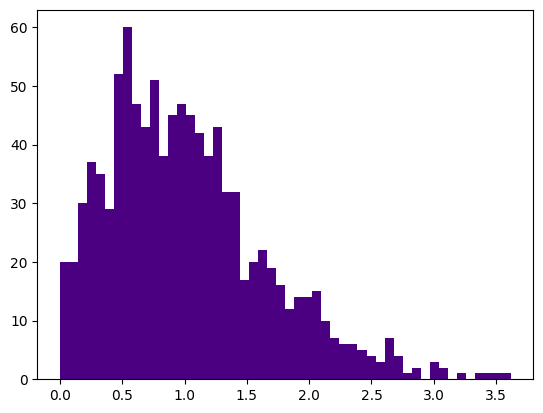

In [2]:
vapp1 = [vapp(lam=5, distribucion=np.random.exponential, scale=1/5) for i in range(1000)]
plt.hist(vapp1, bins=50, color = 'indigo')
plt.show()

### Proceso Poisson Compuesto
  Ahora bien, un Proceso Poisson Compuesto es un Proceso estocástico $\{W(t)\}_{t\geq 0}$ tal que

  $$ W(t) = \sum_{i=1}^{N(t)}X_i$$

  donde $X_1, X_2, X_3, ...$ son variables aleatorias i.i.d. independientes de un proceso Poisson  $\{N(t)\}_{t\geq 0}$ de tasa $\lambda$.

**Pseudo-Código para simular un Proceso Poisson Compuesto**
1. Generamos un Proceso Poisson $\{N(t)\}_{t\geq 0}$ de tasa $\lambda$.
2. Generamos $X_1, ..., X_m$ donde $m = máx\{N(t) : t \geq 0\}$.
3. Generamos las variables $\{W(t)\}_{t\geq 0}$ haciendo la suma truncada por cada tiempo del Proceso Poisson.

Para hacer esto usaremos la clase ProcesoPoisson de notebooks anteriores.

In [3]:
class ProcesoPoisson:
  def __init__(self, lamb):
    '''
    lamb : tasa de ocurrencia del proceso
    self.proceso : dataframe con los tiempos de ocurrencia de cada evento
    self.pp_suma : dataframe con los tiempos de ocurrencia de la suma de los procesos
    self.pp1 : dataframe con los tiempos de ocurrencia del primer proceso (para sumar)
    self.pp2 : dataframe con los tiempos de ocurrencia del segundo proceso (para sumar)
    '''
    self.lamb = lamb
    self.proceso = pd.DataFrame()
    self.pp_suma = pd.DataFrame()
    self.pp1 = pd.DataFrame()
    self.pp2 = pd.DataFrame()

  # Simular con tiempos de interocurrencia
  def simular(self, t):
    llegadas = [0]
    while llegadas[-1] < t:
        ti = np.random.exponential(1 / self.lamb)
        llegadas.append(llegadas[-1] + ti)
    N = len(llegadas)
    self.proceso = pd.DataFrame({'n': range(N), 'T_n': llegadas})
    return self.proceso

  # Graficar el proceso Poisson
  def plot(self):
    plt.figure(figsize=(7, 4))
    for i in range(len(self.proceso['T_n']) - 1):
        # Línea horizontal
        plt.plot([self.proceso['T_n'][i], self.proceso['T_n'][i + 1]],
                  [self.proceso['n'][i], self.proceso['n'][i]], color='navy')
        # Línea vertical punteada
        plt.plot([self.proceso['T_n'][i + 1], self.proceso['T_n'][i + 1]],
                  [self.proceso['n'][i], self.proceso['n'][i + 1]], color='navy', linestyle='--')
    plt.scatter(self.proceso['T_n'], self.proceso['n'], color='blue', zorder=3, s=20)
    plt.title(f'Proceso Poisson de tasa {self.lamb}')
    plt.xlabel('Tiempo $t$')
    plt.ylabel('Número de eventos $N(t)$')
    plt.grid()
    plt.show()

  # Dividir el proceso en dos que sean su suma
  def sumandos(self, T, lamb1, lamb2):
    if lamb1 + lamb2 != self.lamb:
        raise Exception('Las tasas no coinciden')
    self.pp1 = ProcesoPoisson(lamb1)
    self.pp2 = ProcesoPoisson(lamb2)
    pp1_datos = self.pp1.simular(T // 2)
    pp2_datos = self.pp2.simular(T // 2)
    summ = list(pp1_datos['T_n']) + list(pp2_datos['T_n'])
    self.pp_suma = pd.DataFrame({'n': range(0, len(summ)), 'T_n': sorted(summ)})
    return self.pp_suma

  # Función auxiliar para graficar la suma
  def _graficar_proceso(self, df, color_linea, color_punto, label):
    for i in range(len(df['T_n']) - 1):
        plt.plot([df['T_n'][i], df['T_n'][i + 1]], [df['n'][i], df['n'][i]], color=color_linea, label=label if i == 0 else None)
        plt.plot([df['T_n'][i + 1], df['T_n'][i + 1]], [df['n'][i], df['n'][i + 1]], color=color_linea, linestyle='--')
    plt.scatter(df['T_n'], df['n'], color=color_punto, zorder=3, s=20)

  # Graficas la suma
  def plot_suma(self):
    plt.figure(figsize=(7, 4))
    self._graficar_proceso(self.pp1.proceso, color_linea='navy', color_punto='blue', label='pp1')
    self._graficar_proceso(self.pp2.proceso, color_linea='red', color_punto='purple', label='pp2')
    self._graficar_proceso(self.pp_suma, color_linea='green', color_punto='lime', label='pp1+pp2')
    plt.title('Suma de Procesos Poisson')
    plt.xlabel('Tiempo $t$')
    plt.ylabel('Número de eventos $N(t)$')
    plt.legend()
    plt.grid()
    plt.show()

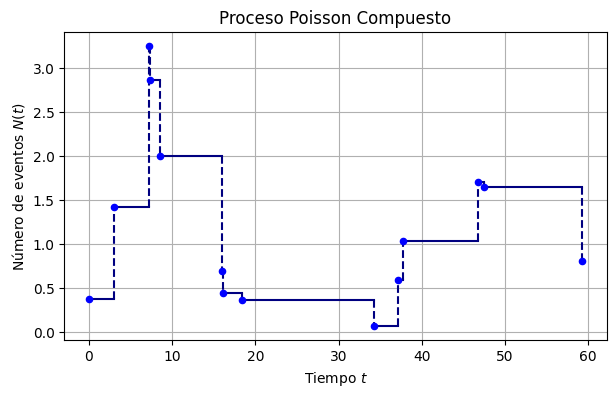

In [4]:
pp1 = ProcesoPoisson(0.2)
Nt1  = pp1.simular(50)

N = len(Nt1)
X_i = np.random.normal(size=N)
Nt1['X_i'] = X_i
Nt1['W'] = Nt1['X_i'].cumsum()
Nt1

def graficar_proceso_escalonado(df):
    plt.figure(figsize=(7, 4))
    for i in range(len(df['T_n']) - 1):
        # Línea horizontal
        plt.plot([df['T_n'][i], df['T_n'][i + 1]],
                  [df['W'][i], df['W'][i]], color='navy')
        # Línea vertical punteada
        plt.plot([df['T_n'][i + 1], df['T_n'][i + 1]],
                  [df['W'][i], df['W'][i + 1]], color='navy', linestyle='--')
    plt.scatter(df['T_n'], df['W'], color='blue', zorder=3, s=20)
    plt.title(f'Proceso Poisson Compuesto')
    plt.xlabel('Tiempo $t$')
    plt.ylabel('Número de eventos $N(t)$')
    plt.grid()
    plt.show()

graficar_proceso_escalonado(Nt1)

Ahora haremos una clase para simular un Proceso Poisson Compuesto

In [5]:
class ProcesoPoissonCompuesto:
  def __init__(self, lamb, distribucion, *args, **kwargs):
    '''
    lamb : tasa de ocurrencia del proceso
    proceso : dataframe con los tiempos de ocurrencia y valores de X_i y W_i
    distribucion : densidad de los X_i, como np.random.normal, np.random.exponential, etc.
    *args, **kwargs : argumentos adicionales para la función de distribución.
    '''
    self.lamb = lamb
    self.distribucion = distribucion
    self.args = args
    self.kwargs = kwargs
    self.proceso = pd.DataFrame()

  def simular(self, iter):
    # Generamos nuestro proceso poisson
    pp1 = ProcesoPoisson(self.lamb)
    Nt1  = pp1.simular(iter)

    # Generamos las X_i y las W_i
    N = len(Nt1)
    X_i = self.distribucion(size=N, *self.args, **self.kwargs)
    Nt1['X_i'] = X_i
    Nt1['W'] = Nt1['X_i'].cumsum()
    self.proceso = Nt1
    return self.proceso

  def plot_compuesto(self):
      plt.figure(figsize=(7, 4))
      for i in range(len(self.proceso['T_n']) - 1):
          # Línea horizontal
          plt.plot([self.proceso['T_n'][i], self.proceso['T_n'][i + 1]],
                    [self.proceso['W'][i], self.proceso['W'][i]], color='navy')
          # Línea vertical punteada
          plt.plot([self.proceso['T_n'][i + 1], self.proceso['T_n'][i + 1]],
                    [self.proceso['W'][i], self.proceso['W'][i + 1]], color='navy', linestyle='--')
      plt.scatter(self.proceso['T_n'], self.proceso['W'], color='blue', zorder=3, s=20)
      plt.title(f'Proceso Poisson Compuesto')
      plt.xlabel('Tiempo $t$')
      plt.ylabel('Número de eventos $N(t)$')
      plt.grid()
      plt.show()

Ahora probemosla

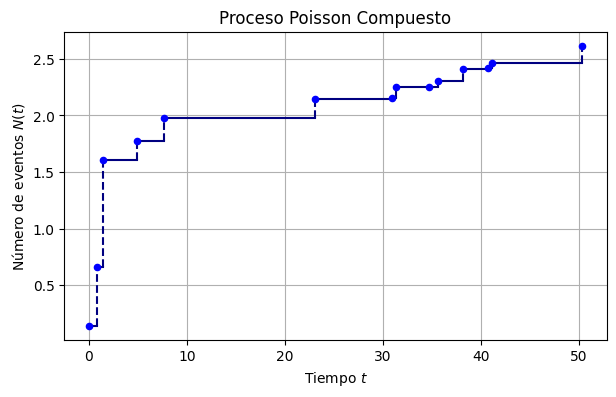

In [6]:
ppc2 = ProcesoPoissonCompuesto(0.2, np.random.exponential, scale=0.2)
ppc2.simular(50)
ppc2.plot_compuesto()

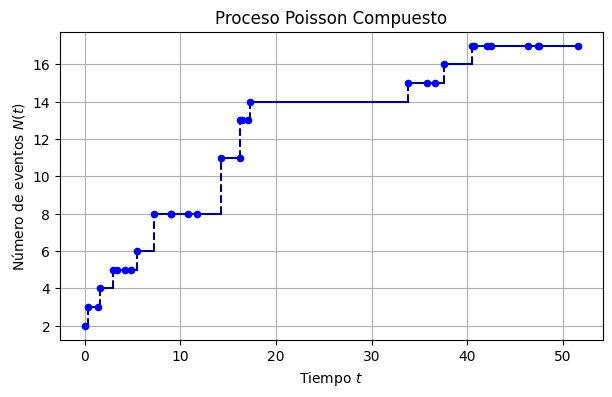

In [7]:
ppc3 = ProcesoPoissonCompuesto(0.5, np.random.binomial, n = 10, p = 0.05)
ppc3.simular(50)
ppc3.plot_compuesto()

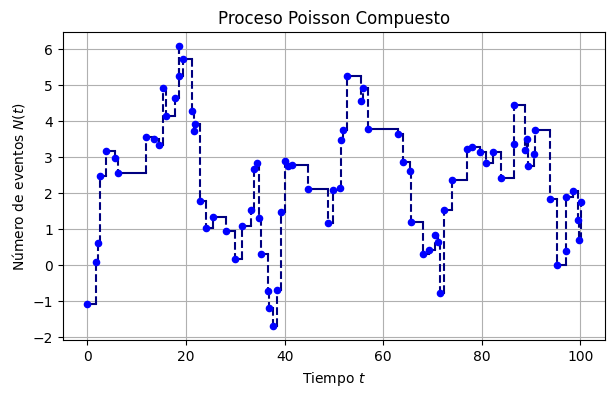

In [8]:
np.random.seed(123)
ppc4 = ProcesoPoissonCompuesto(0.7, np.random.normal, loc = 0, scale = 1)
ppc4.simular(100)
ppc4.plot_compuesto()

### Modelo de Cramer-Lundberg

Supongamos que una compañía de seguros comienza con un capital inicial $ u\geq 0$ y que recibe primas constantes a una tasa de $c>0$ por unidad de tiempo. Las reclamaciones de los asegurados llegan en tiempos aleatorios que siguen un proceso de Poisson homogéneo $\{N(t)\}_{t \geq 0}$ con tasa $\lambda > 0$.

Cada reclamación representa una pérdida para la compañía. Denotamos los montos de las reclamaciones como $Z_1, Z_2, ...$ los cuales son variables aleatorias no negativas, independientes e idénticamente distribuidas.

Entonces, el capital de la compañía en el tiempo $t$, denotado $X(t)$ se modela como

$$
X(t) = u + ct - \sum_{k=1}^{N(t)} Z_k
$$

Donde:

* $u$ es el capital inicial de la aseguradora,
* $ct$ es la cantidad total recolectada en primas hasta el tiempo $t$,
* $\sum_{k=1}^{N(t)} Z_k$ es el monto total pagado por reclamaciones hasta ese tiempo.

Este modelo se conoce como el modelo clásico de riesgo o modelo de Cramer Lundberg

Veamos cómo se ven las trayectorias de este proceso.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Proceso de Poisson compuesto
class ProcesoPoissonCompuesto:
    def __init__(self, lamb, dist_montos, *args, **kwargs):
        self.lamb = lamb
        self.dist_montos = lambda n: dist_montos(size=n, *args, **kwargs)

    def simular(self, tiempo_total):
        N = np.random.poisson(self.lamb * tiempo_total)
        T_n = np.sort(np.random.uniform(0, tiempo_total, size=N))  # tiempos aleatorios
        W = self.dist_montos(N)  # montos de los reclamos
        return {'T_n': T_n, 'W': W}


# Modelo de Cramer-Lundberg
class CramerLundberg:
    def __init__(self, u, c, lamb, distribucion, *args, **kwargs):
        '''
        u : capital inicial
        c : tasa de primas por unidad de tiempo
        lamb : tasa de reclamos (Poisson)
        distribucion : np.random.exponential, np.random.normal, etc.
        *args, **kwargs : argumentos extra para la distribución
        '''
        self.u = u
        self.c = c
        self.lamb = lamb
        self.distribucion = distribucion
        self.args = args
        self.kwargs = kwargs

    def simular(self, T):
        ppc = ProcesoPoissonCompuesto(self.lamb, self.distribucion, *self.args, **self.kwargs)
        Nt = ppc.simular(T)
        T_n = np.array(Nt['T_n'])
        W = np.array(Nt['W'])
        suma_W = np.cumsum(W)

        # Tiempo continuo
        tiempo = np.arange(0, T, 0.01)

        # Interpolación de los saltos
        T_n_con_cero = np.concatenate([[0], T_n])
        suma_con_cero = np.concatenate([[0], suma_W])
        f_reclamos = interp1d(T_n_con_cero, suma_con_cero, kind='previous', bounds_error=False, fill_value=(0, suma_W[-1]))

        # Capital en el tiempo
        riesgo = self.u + self.c * tiempo - f_reclamos(tiempo)
        return tiempo, riesgo, T_n, self.u + self.c * T_n - suma_W

    def graficar(self, T=10):
        tiempo, riesgo, T_n, X_saltos = self.simular(T)
        plt.figure(figsize=(10, 5))
        plt.plot(tiempo, riesgo, label='Capital de la compañía', color = 'indigo')
        plt.scatter(T_n, X_saltos, color='navy', zorder=2)
        plt.title('Modelo de Cramer-Lundberg')
        plt.xlabel('Tiempo')
        plt.ylabel('Capital')
        plt.legend()
        plt.grid(True)
        plt.show()


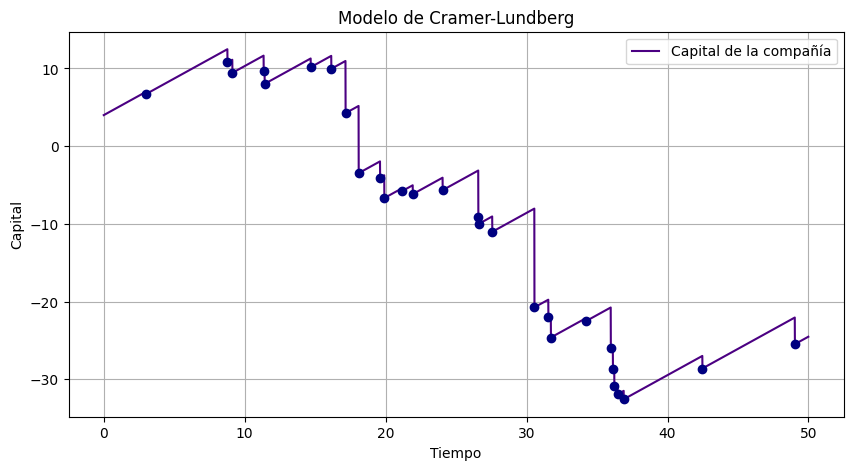

In [45]:
np.random.seed(123)
cl2 = CramerLundberg(u=4, c=1, lamb=0.5, distribucion=np.random.exponential, scale=3)
cl2.graficar(T=50)

Veamos algunos ejemplos:

In [29]:
# Ejemplo 3: Reclamos exponenciales pequeños, tasa de primas alta
cl3 = CramerLundberg(u=50,c=10,lamb=1.5,distribucion=np.random.exponential,scale=5) # media de los reclamos = 5 (pequeños))

# Ejemplo 4: Reclamos exponenciales grandes, tasa de primas baja
cl4 = CramerLundberg(u=50, c=5, lamb=1.5, distribucion=np.random.exponential, scale=15) # media de los reclamos = 15 (grandes))

# Ejemplo 5: Reclamos normales
cl5 = CramerLundberg(u=80, c=8, lamb=2, distribucion=np.random.normal, loc=10, scale=3)

# Ejemplo 6: Reclamos mixtos Gamma (reclamos más pesados en cola)
cl6 = CramerLundberg(u=60, c=9, lamb=1.2, distribucion=np.random.gamma, shape=2.0, scale=6.0) # k, theta

# Ejemplo 7: Reclamos lognormales
cl7 = CramerLundberg(u=70, c=7, lamb=1.8, distribucion=np.random.lognormal, mean=1.5, sigma=0.8) # Alta variabilidad y colas pesadas

Ahora grafiquemos para visualizarlos

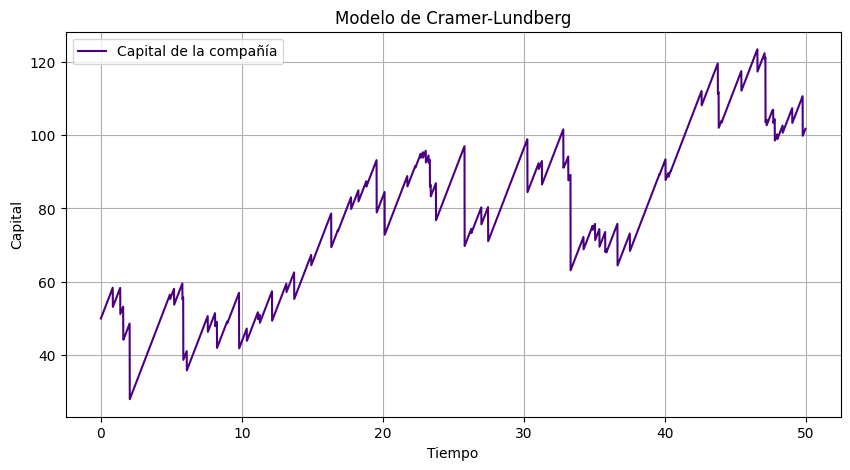

In [33]:
cl3.graficar(50)

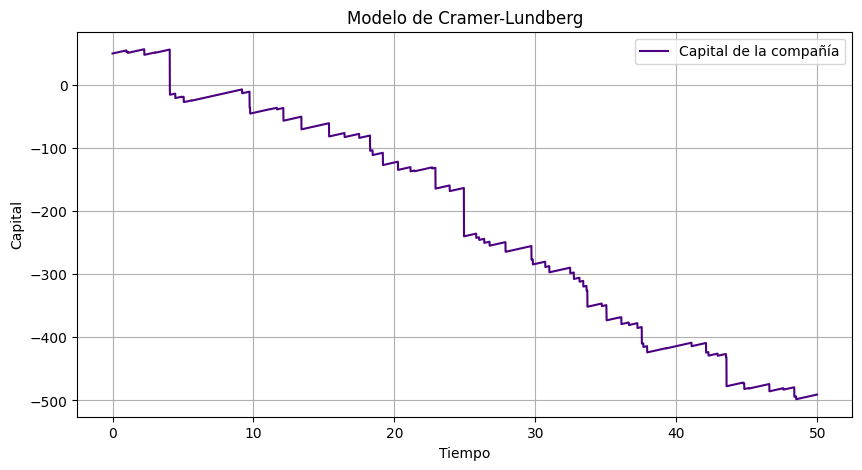

In [39]:
cl4.graficar(50)

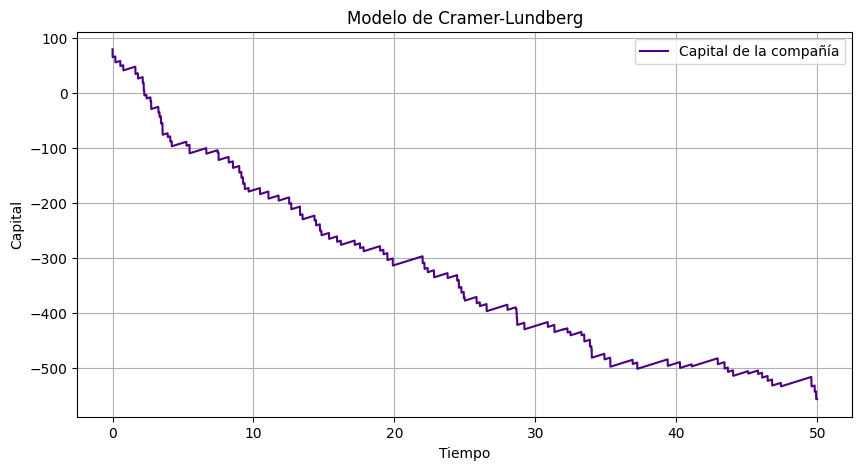

In [40]:
cl5.graficar(50)

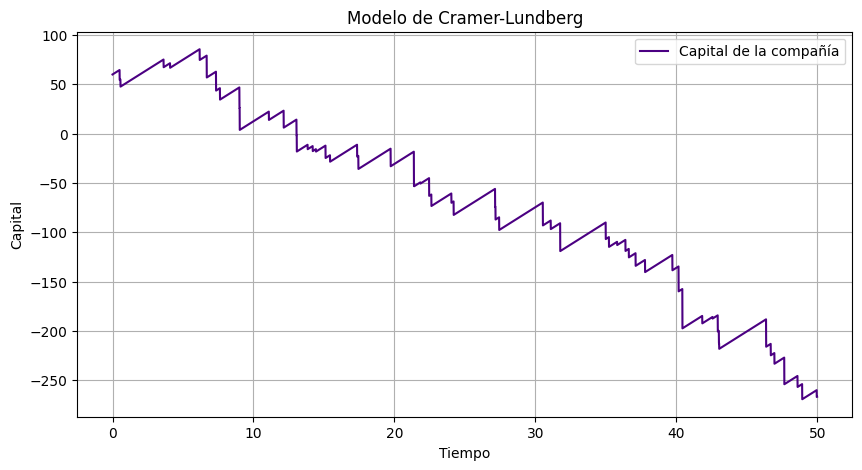

In [41]:
cl6.graficar(50)

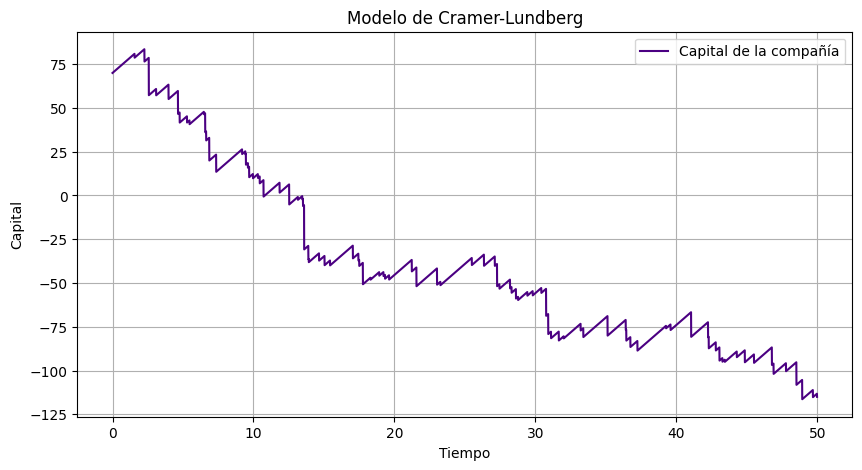

In [42]:
cl7.graficar(50)